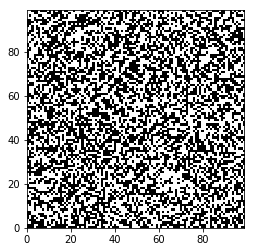

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Define geometry
## 2D, L^2

L = 100
MCS = L**2

grid_x = range(L)
grid_y = range(L)
grid_coordinates_x, grid_coordinates_y = np.meshgrid(grid_x, grid_y) 
grid_spins = np.random.rand(L,L)

grid_spins[grid_spins>=0.5] = 1
grid_spins[grid_spins<0.5] = -1

def grid_plot(x, y, z):
    import matplotlib.cm as cm
    image = plt.imshow(z, extent=(x.min(), x.max(), y.min(),y.max()), interpolation='nearest', cmap=cm.gray)
    return image
    
spin_plot = grid_plot(grid_coordinates_x, grid_coordinates_y, grid_spins)
plt.show(spin_plot)



# Initial conditions
## All spin up or all down or random

# Determine initial energy
## Depends on up down or random

# Choose spin at random 
## Check if the energy gain is positive or negative
### Depending on losing or gaining directly accept or accept with a certain probability

# If flipped, adapt the initial energy. 
